In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Leggi il dataset ---
df = pd.read_excel("marzo2022_settembre2025.xlsx", sheet_name="dati pedoni orari")

# Combina data + ora in datetime
df["datetime"] = pd.to_datetime(df["data"].astype(str) + " " + df["ora"].astype(str))

# Rimuovi colonne originali
df = df.drop(columns=["data", "ora"])

# --- 2. Seleziona telecamera ---
telecamera_scelta = "Arcoribellino"
df_cam = df[df["telecamera"] == telecamera_scelta].copy()
df_cam = df_cam.reset_index(drop=True)

# --- 3. Crea colonne utili ---
df_cam["giorno"] = df_cam["datetime"].dt.date
df_cam["ora"] = df_cam["datetime"].dt.hour + df_cam["datetime"].dt.minute / 60

df_cam


,telecamera,entra,uscita,datetime,giorno,ora
0,Arcoribellino,1,2,2022-03-01 00:00:00,2022-03-01,0.000000
1,Arcoribellino,1,0,2022-03-01 01:00:00,2022-03-01,1.000000
2,Arcoribellino,0,0,2022-03-01 02:00:00,2022-03-01,2.000000
3,Arcoribellino,0,0,2022-03-01 03:00:00,2022-03-01,3.000000
4,Arcoribellino,0,0,2022-03-01 04:00:00,2022-03-01,4.000000
...,...,...,...,...,...,...
25884,Arcoribellino,17,14,2025-09-30 20:00:00,2025-09-30,20.000000
25885,Arcoribellino,18,8,2025-09-30 21:00:00,2025-09-30,21.000000
25886,Arcoribellino,5,12,2025-09-30 22:00:00,2025-09-30,22.000000
25887,Arcoribellino,3,11,2025-09-30 23:00:00,2025-09-30,23.000000


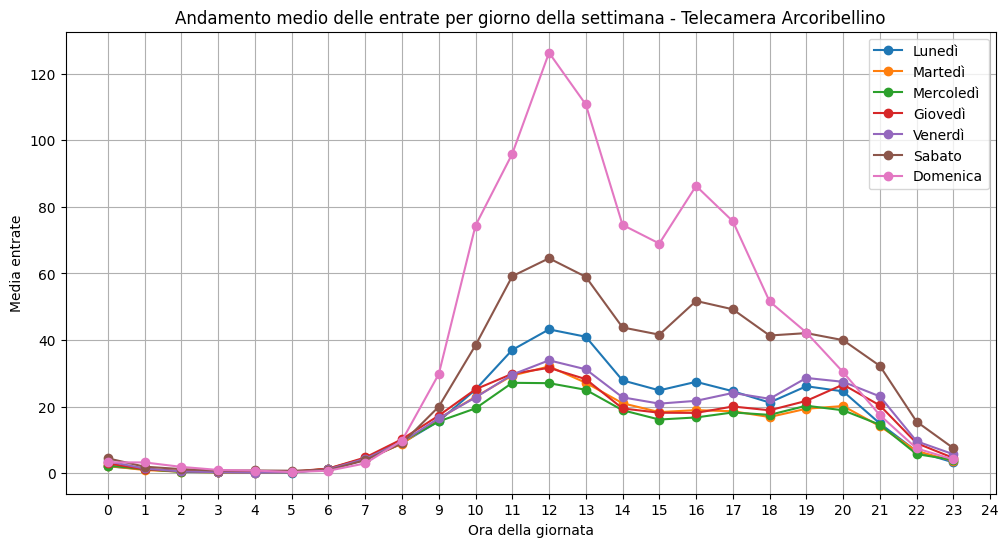

In [18]:
# Estrai giorno della settimana e ora
df_cam["giorno_settimana"] = df_cam["datetime"].dt.dayofweek  # 0=lunedì, 6=domenica
df_cam["ora"] = df_cam["datetime"].dt.hour

# Raggruppa per giorno della settimana e ora, calcola la media delle entrate
weekly_avg = df_cam.groupby(["giorno_settimana", "ora"])["entra"].mean().reset_index()

# Definisci i nomi dei giorni
giorni = ["Lunedì", "Martedì", "Mercoledì", "Giovedì", "Venerdì", "Sabato", "Domenica"]

# Grafico
plt.figure(figsize=(12, 6))
for i in range(7):
    subset = weekly_avg[weekly_avg["giorno_settimana"] == i]
    plt.plot(subset["ora"], subset["entra"], marker='o', label=giorni[i])

plt.xlabel("Ora della giornata")
plt.ylabel("Media entrate")
plt.title(f"Andamento medio delle entrate per giorno della settimana - Telecamera {telecamera_scelta}")
plt.xticks(range(0,25))
plt.grid(True)
plt.legend()
plt.show()


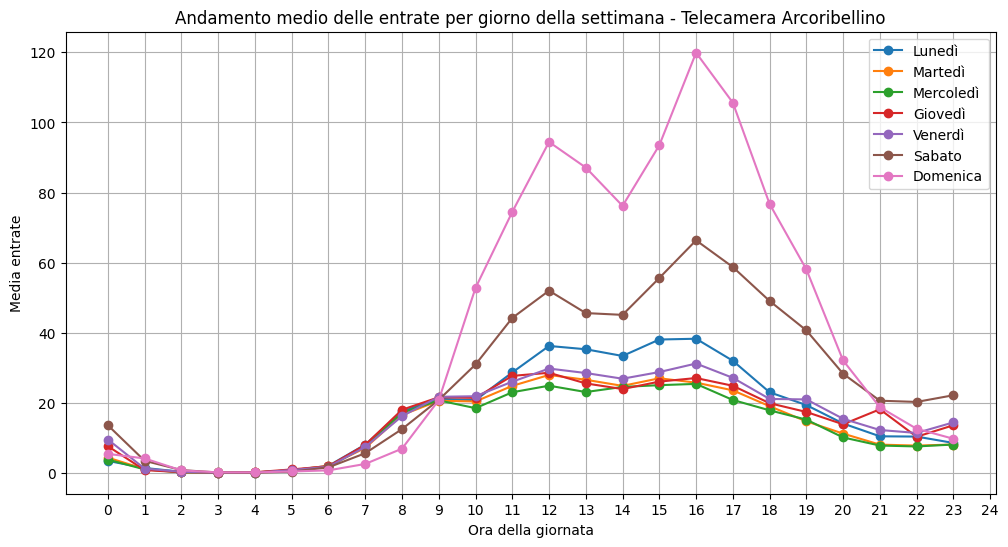

In [19]:
# Estrai giorno della settimana e ora
df_cam["giorno_settimana"] = df_cam["datetime"].dt.dayofweek  # 0=lunedì, 6=domenica
df_cam["ora"] = df_cam["datetime"].dt.hour

# Raggruppa per giorno della settimana e ora, calcola la media delle entrate
weekly_avg = df_cam.groupby(["giorno_settimana", "ora"])["uscita"].mean().reset_index()

# Definisci i nomi dei giorni
giorni = ["Lunedì", "Martedì", "Mercoledì", "Giovedì", "Venerdì", "Sabato", "Domenica"]

# Grafico
plt.figure(figsize=(12, 6))
for i in range(7):
    subset = weekly_avg[weekly_avg["giorno_settimana"] == i]
    plt.plot(subset["ora"], subset["uscita"], marker='o', label=giorni[i])

plt.xlabel("Ora della giornata")
plt.ylabel("Media entrate")
plt.title(f"Andamento medio delle entrate per giorno della settimana - Telecamera {telecamera_scelta}")
plt.xticks(range(0,25))
plt.grid(True)
plt.legend()
plt.show()


In [20]:
# Aggrega per giorno (somma ingressi e uscite)
daily_totals = df_cam.groupby("giorno")[["entra", "uscita"]].sum().reset_index()

# Controllo
print(daily_totals)
print(f"Numero di giorni unici: {len(daily_totals)}")


          giorno  entra  uscita
0     2022-03-01    286     274
1     2022-03-02    291     309
2     2022-03-03    263     296
3     2022-03-04    292     283
4     2022-03-05    763     769
...          ...    ...     ...
1120  2025-09-26    375     399
1121  2025-09-27    708     686
1122  2025-09-28    973    1013
1123  2025-09-29    298     327
1124  2025-09-30    294     327

[1125 rows x 3 columns]
Numero di giorni unici: 1125


In [21]:
import pandas as pd
import numpy as np

# Assicurati che 'giorno' sia in formato datetime
daily_totals["giorno"] = pd.to_datetime(daily_totals["giorno"])

# Aggiungi il giorno della settimana (0=lunedì, 6=domenica)
daily_totals["giorno_settimana"] = daily_totals["giorno"].dt.weekday

# Calcola media e deviazione standard per ogni giorno della settimana
stats_settimana = daily_totals.groupby("giorno_settimana")["entra"].agg(["mean", "std"]).reset_index()
stats_settimana = stats_settimana.rename(columns={"mean": "media", "std": "devstd"})

# Unisci le statistiche al dataframe originale
daily_totals = daily_totals.merge(stats_settimana, on="giorno_settimana", how="left")

# Identifica solo i giorni con afflusso alto (>2 deviazioni standard sopra la media dello stesso giorno della settimana)
daily_totals["anomalia"] = daily_totals["entra"] > (daily_totals["media"] + 2 * daily_totals["devstd"])

# Pulizia: rimuovi colonne temporanee
daily_totals = daily_totals.drop(columns=["media", "devstd"])

# Controllo
print(daily_totals.head())
print(daily_totals["anomalia"].value_counts())


      giorno  entra  uscita  giorno_settimana  anomalia
0 2022-03-01    286     274                 1     False
1 2022-03-02    291     309                 2     False
2 2022-03-03    263     296                 3     False
3 2022-03-04    292     283                 4     False
4 2022-03-05    763     769                 5     False
anomalia
False    1084
True       41
Name: count, dtype: int64


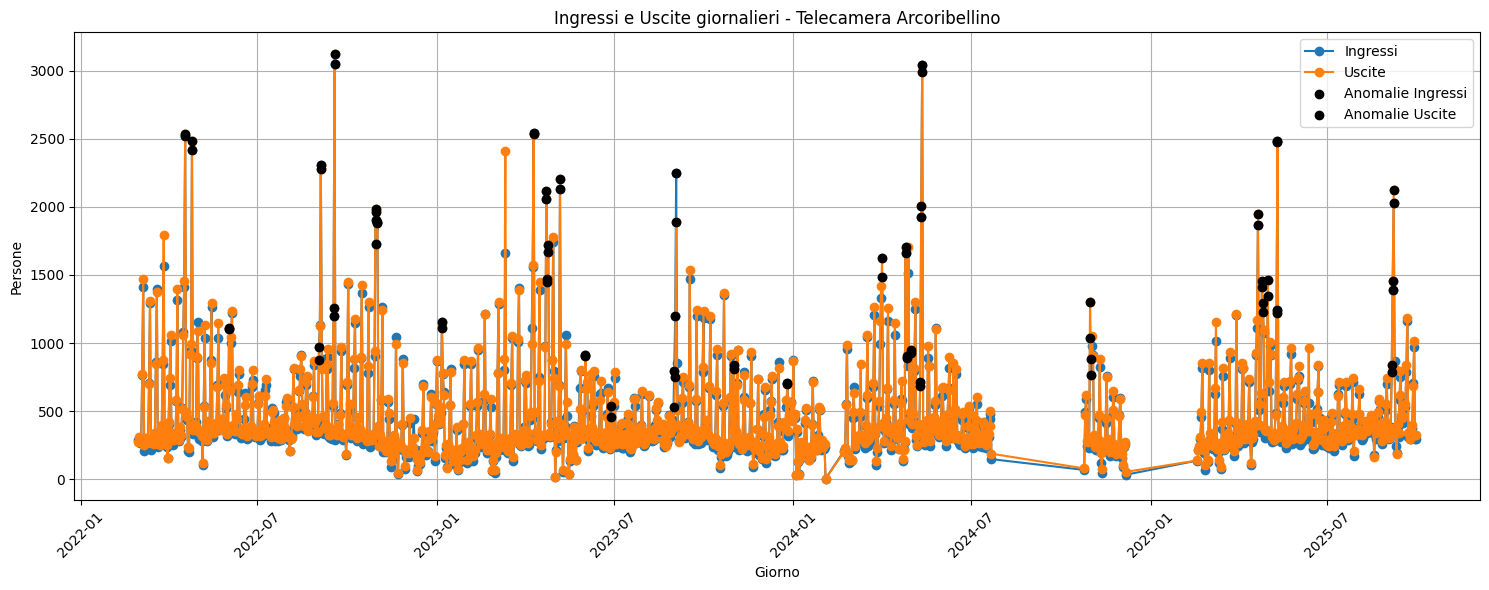

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

# Linee ingressi e uscite
plt.plot(daily_totals["giorno"], daily_totals["entra"], marker='o', label="Ingressi")
plt.plot(daily_totals["giorno"], daily_totals["uscita"], marker='o', label="Uscite")

# Evidenzia giorni anomali
anomali = daily_totals[daily_totals["anomalia"]]
plt.scatter(anomali["giorno"], anomali["entra"], color="black", label="Anomalie Ingressi", zorder=5)
plt.scatter(anomali["giorno"], anomali["uscita"], color="black", label="Anomalie Uscite", zorder=5)

plt.xlabel("Giorno")
plt.ylabel("Persone")
plt.title(f"Ingressi e Uscite giornalieri - Telecamera {telecamera_scelta}")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


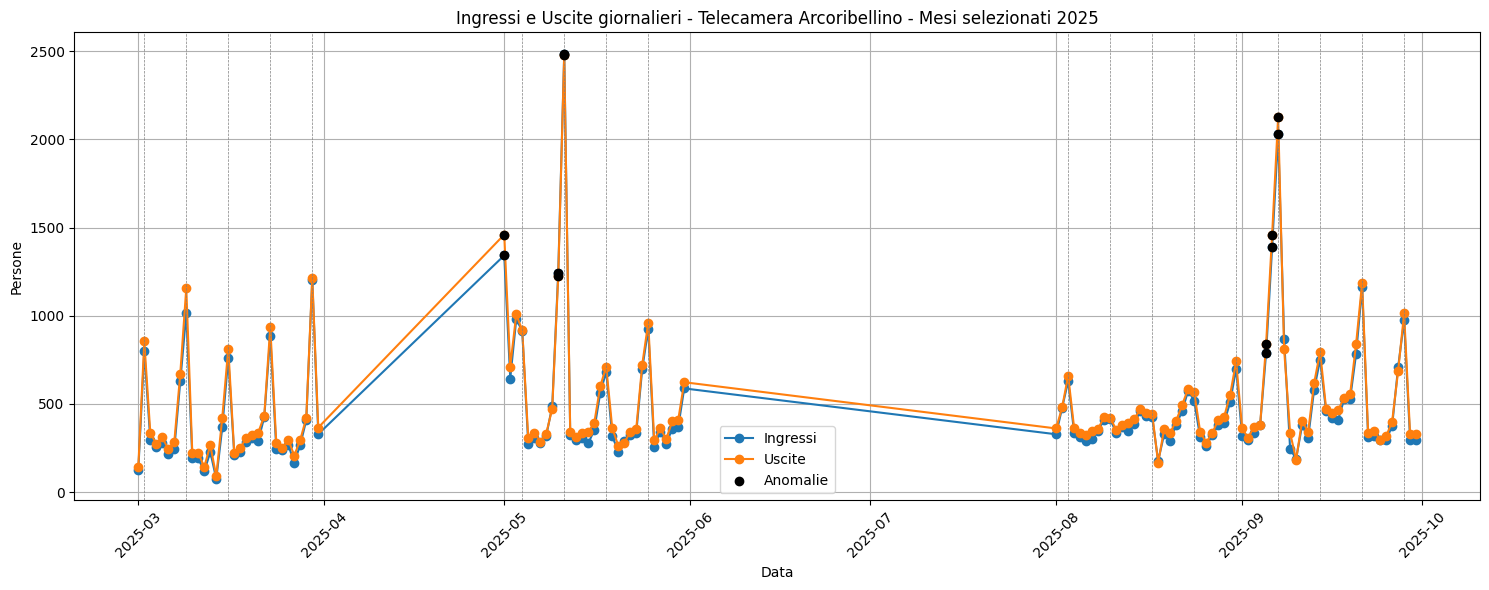

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Assicurati che 'giorno' sia datetime
daily_totals["giorno"] = pd.to_datetime(daily_totals["giorno"])

# Seleziona solo l'anno 2025 e i mesi indicati
selected_months = [3, 5, 8, 9]  # marzo, maggio, agosto, settembre
filtered = daily_totals[
    (daily_totals["giorno"].dt.year == 2025) &
    (daily_totals["giorno"].dt.month.isin(selected_months))
].copy()

# Grafico
plt.figure(figsize=(15,6))
plt.plot(filtered["giorno"], filtered["entra"], marker='o', label="Ingressi")
plt.plot(filtered["giorno"], filtered["uscita"], marker='o', label="Uscite")

# Evidenzia eventuali anomalie
if "anomalia" in filtered.columns:
    anomali = filtered[filtered["anomalia"]]
    plt.scatter(anomali["giorno"], anomali["entra"], color="black", label="Anomalie", zorder=5)
    plt.scatter(anomali["giorno"], anomali["uscita"], color="black", zorder=5)

# Linee verticali sottili per le domeniche
sundays = filtered[filtered["giorno"].dt.weekday == 6]["giorno"]
for sunday in sundays:
    plt.axvline(sunday, color='gray', linestyle='--', linewidth=0.5)

plt.title(f"Ingressi e Uscite giornalieri - Telecamera {telecamera_scelta} - Mesi selezionati 2025")
plt.xlabel("Data")
plt.ylabel("Persone")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


MSE: 49496.57
R2: 0.70
MAE: 128.72


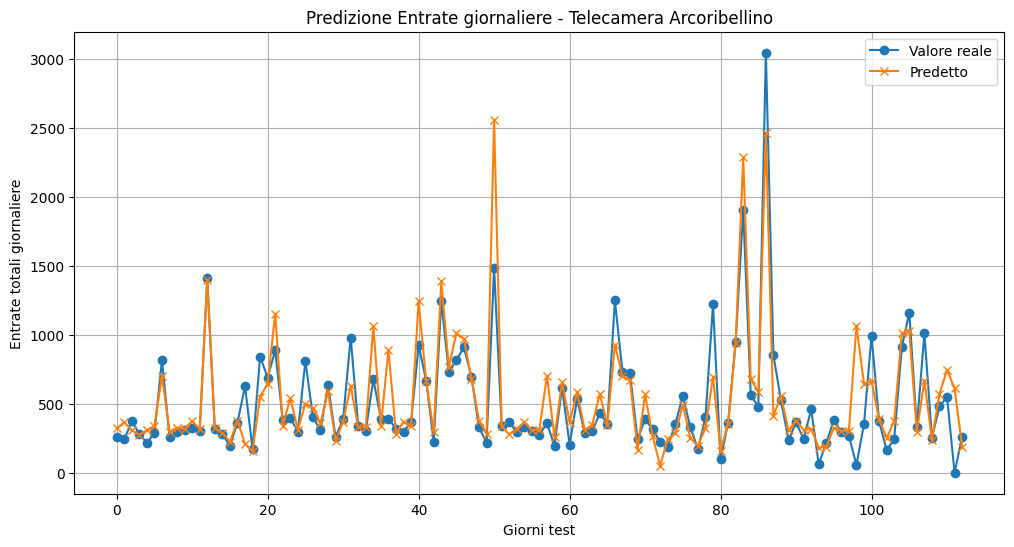

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ----------------------------
# 1️⃣ Prepara i dati da daily_totals
# ----------------------------
daily_totals["giorno"] = pd.to_datetime(daily_totals["giorno"])

# Feature temporali giornaliere
daily_totals["giorno_settimana"] = daily_totals["giorno"].dt.weekday
daily_totals["mese"] = daily_totals["giorno"].dt.month
daily_totals["giorno_mese"] = daily_totals["giorno"].dt.day

# Target e feature
y = daily_totals["entra"]
# Assumiamo che ci sia una colonna Special (o usare anomalia come proxy)
X = daily_totals[["giorno_settimana", "mese", "giorno_mese", "anomalia"]]

# ----------------------------
# 2️⃣ Split train/test
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# ----------------------------
# 3️⃣ Modello Gradient Boosting
# ----------------------------
model = GradientBoostingRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42
)
model.fit(X_train, y_train)

# Predizioni
y_pred = model.predict(X_test)

# ----------------------------
# 4️⃣ Valutazione
# ----------------------------
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.2f}")
print(f"MAE: {mae:.2f}")

# ----------------------------
# 5️⃣ Visualizza predizioni
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Valore reale", marker='o')
plt.plot(y_pred, label="Predetto", marker='x')
plt.xlabel("Giorni test")
plt.ylabel("Entrate totali giornaliere")
plt.title(f"Predizione Entrate giornaliere - Telecamera {telecamera_scelta}")
plt.legend()
plt.grid(True)
plt.show()


In [25]:

# Giorno inventato
giorno_inventato = pd.to_datetime("2025-12-07")

# Costruisci dataframe giornaliero
df_fake = pd.DataFrame({
    "giorno": [giorno_inventato],
    "giorno_settimana": [giorno_inventato.weekday()],
    "mese": [giorno_inventato.month],
    "giorno_mese": [giorno_inventato.day],
    "anomalia": [1]  # supponiamo non sia un giorno top30
})

print(df_fake)

# Predizione totale giornaliera
X_fake = df_fake[["giorno_settimana", "mese", "giorno_mese", "anomalia"]]
y_pred = model.predict(X_fake)

print(f"Predizione totale entrate per {giorno_inventato.date()}: {y_pred[0]:.0f}")


      giorno  giorno_settimana  mese  giorno_mese  anomalia
0 2025-12-07                 6    12            7         1
Predizione totale entrate per 2025-12-07: 1770


In [26]:
import joblib

# Salva il modello in un file .pkl
filename = "pedestrians_model.pkl"
joblib.dump(model, filename)

print(f"Modello salvato in {filename}")


Modello salvato in pedestrians_model.pkl
